# Test basic framework functionality

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import gstools as gs

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import plot
import data_utils
import krige_tools
import fields
import cov_model
import cokrige

## Load and view data

In [4]:
# read 5-degree monthly data and subset to US for faster testing
time = "2019-07-01"
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly.nc")

ds

<xarray.Dataset>
Dimensions:   (lat: 35, lon: 72, time: 75)
Coordinates:
  * lon       (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat       (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 67.5 72.5 77.5 82.5
  * time      (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-11-01
Data variables:
    sif       (lon, lat, time) float32 ...
    sif_var   (lon, lat, time) float32 ...
    xco2      (lon, lat, time) float32 ...
    xco2_var  (lon, lat, time) float32 ...

## Setup fields and fit empirical kernels (params from variogram model)

In [5]:
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]
Z = fields.MultiField(ds_xco2, ds_sif, "2019-07-01", timedelta=-2, standardize=True)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [6]:
bin_edges = np.linspace(0, 300, 20)
k1 = cov_model.Matern()
k2 = cov_model.Matern()
model, vario_obj = cov_model.BivariateMatern(Z, k1, k2)._empirical_kernels(bin_edges, sampling_size=2e3)
predictor = cokrige.Cokrige(Z, model, fast_dist=True)

In [7]:
model.get_params()

{'sigma_11': 0.4784271266233714,
 'nu_11': 2.5,
 'len_scale_11': 19.27164855657818,
 'nugget_11': 0.0,
 'nu_12': 2.5,
 'len_scale_12': 11.962073316822439,
 'rho': -0.04530547215701014,
 'sigma_22': 0.8757827460139787,
 'nu_22': 2.5,
 'len_scale_22': 4.652498077066697,
 'nugget_22': 0.0}

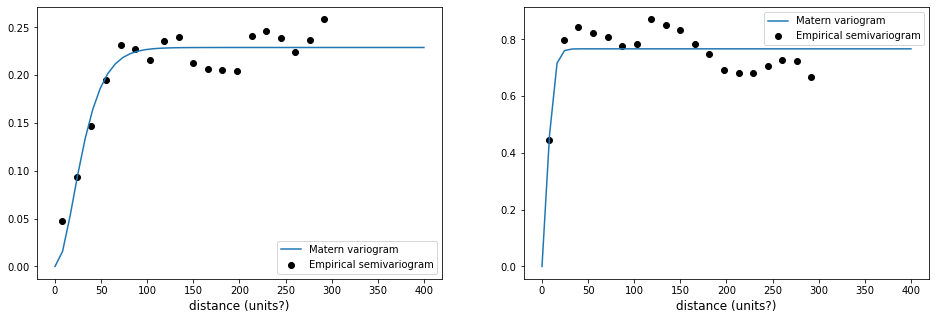

In [8]:
## Analyze sample variograms
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

vario_obj[0]["model"].plot(func="variogram", x_max=400, ax=ax[0])
ax[0].scatter(vario_obj[0]["bins"], vario_obj[0]["emp_semivariogram"], color="k", label="Empirical semivariogram")
ax[0].legend()
ax[0].set_xlabel("distance (units?)", size=12)

vario_obj[1]["model"].plot(func="variogram", x_max=400, ax=ax[1])
ax[1].scatter(vario_obj[1]["bins"], vario_obj[1]["emp_semivariogram"], color="k", label="Empirical semivariogram")
ax[1].legend()
ax[1].set_xlabel("distance (units?)", size=12);

## Parameter estimation

In [20]:
res = predictor.fit(init_guess=[1.0, 1e3, 0.1, 1e3, -0.1, 1.0, 1e3, 0.1], options={"maxiter": 100})
model.get_params()

      fun: 1037.7716123777132
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.35744973e+01, -1.81173261e-01,  5.95928213e+00,  0.00000000e+00,
        2.27373675e-05, -2.72848411e-03,  0.00000000e+00,  2.20649963e+03])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 153
      nit: 15
     njev: 17
   status: 1
  success: False
        x: array([ 2.72888555e+00,  1.12716785e+03,  0.00000000e+00,  1.00000000e+03,
       -5.42569666e-04,  1.00000000e-08,  1.00000208e+03,  0.00000000e+00])

In [26]:
def empirical_semivariogram(field, bin_edges, sampling_size=None, sampling_seed=None):
    """
    NOTE: 
    - formulation seems correct, but distances are euclidean and not interpretable.
    - Haversine distance (unknown units) available through variogram.estimator.unstructured
    """
    bin_center, gamma = gs.vario_estimate_unstructured(
        (field.coords[:, 1], field.coords[:, 0]),
        field.values,
        bin_edges,
        sampling_size=sampling_size,
        sampling_seed=sampling_seed,
        estimator="cressie",
    )
    return bin_center, gamma

p = model.get_params()
mod1 = gs.Matern(dim=2, var=p["sigma_11"]**2, nu=2.5, len_scale=p["len_scale_11"], nugget=p["nugget_11"])
esv1 = empirical_semivariogram(Z.field_1, bin_edges)

mod2 = gs.Matern(dim=2, var=p["sigma_22"]**2, nu=2.5, len_scale=p["len_scale_22"], nugget=p["nugget_22"])
esv2 = empirical_semivariogram(Z.field_2, bin_edges)

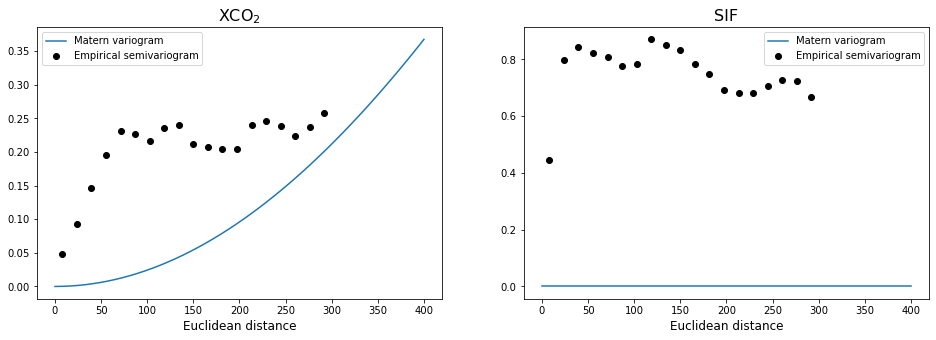

In [31]:
## Analyze sample variograms
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].set_title("XCO$_2$", size=16)
mod1.plot(func="variogram", x_max=400, ax=ax[0])
ax[0].scatter(esv1[0], esv1[1], color="k", label="Empirical semivariogram")
ax[0].legend()
ax[0].set_xlabel("Euclidean distance", size=12)

ax[1].set_title("SIF", size=16)
mod2.plot(func="variogram", x_max=400, ax=ax[1])
ax[1].scatter(esv2[0], esv2[1], color="k", label="Empirical semivariogram")
ax[1].legend()
ax[1].set_xlabel("Euclidean distance", size=12);

## Cokriging over XCO2 grid

In [9]:
pred_loc = krige_tools.land_grid(res=5, lat_lwr=-60, lat_upr=75)
pred, pred_err = predictor(pred_loc)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [10]:
ds_pred = data_utils.to_xarray(pred_loc, pred=pred, pred_err=pred_err)
ds_pred

<xarray.Dataset>
Dimensions:   (lat: 27, lon: 72)
Coordinates:
  * lon       (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat       (lat) float64 -57.5 -52.5 -47.5 -42.5 ... 57.5 62.5 67.5 72.5
Data variables:
    pred      (lon, lat) float64 nan nan nan nan nan ... nan 405.1 404.0 403.3
    pred_err  (lon, lat) float64 nan nan nan nan nan ... nan 0.4645 0.4341 1.273

## Plot data and results in a grid

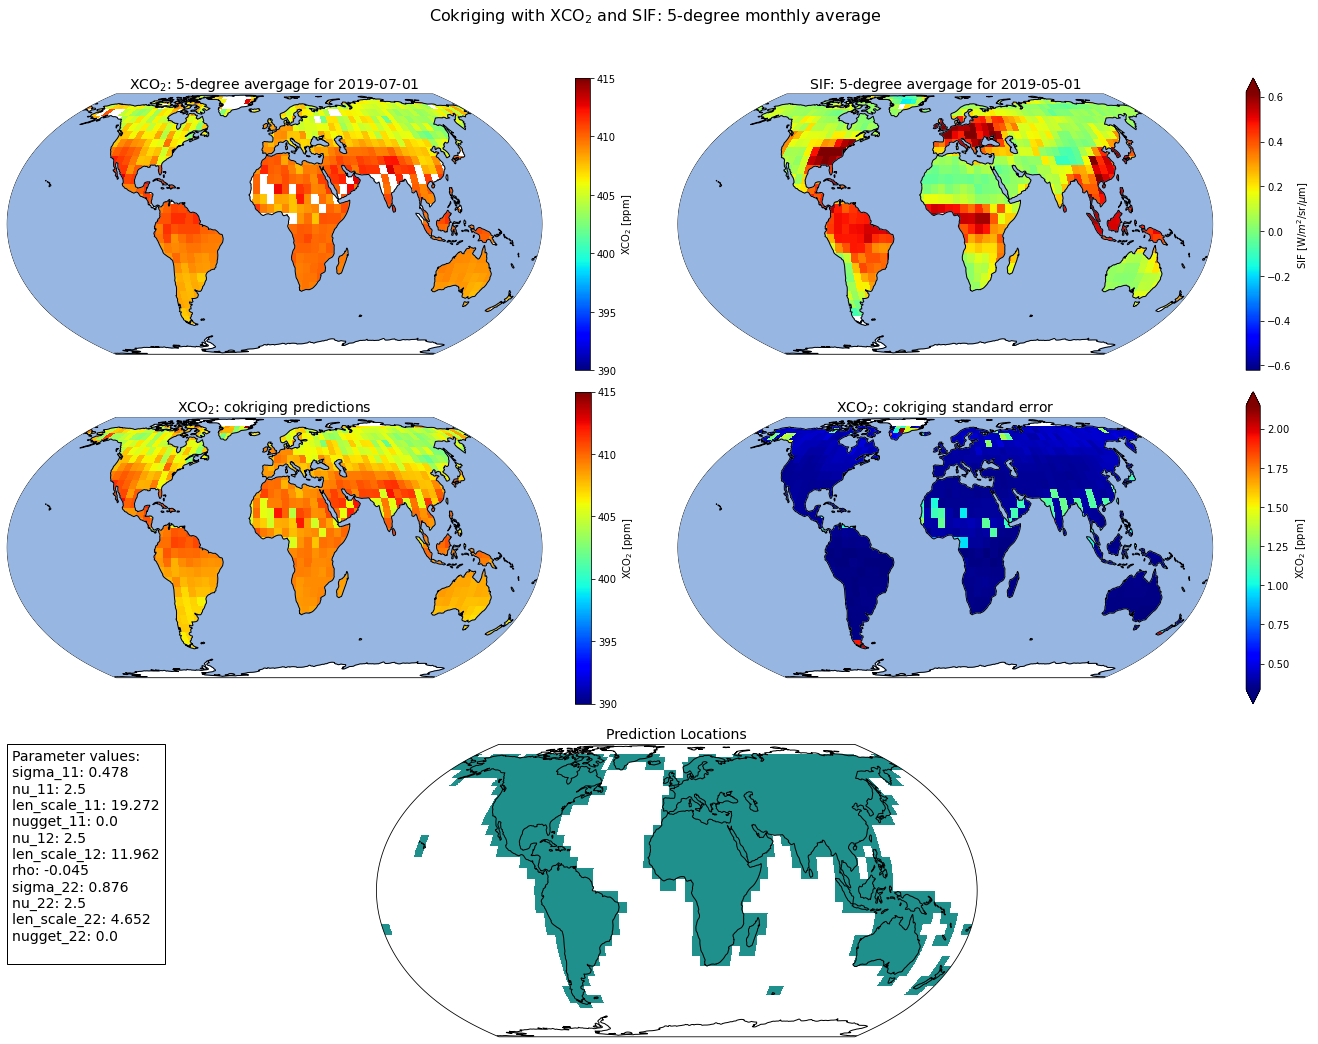

In [12]:
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(100, 100)

fig.suptitle(
    "Cokriging with XCO$_2$ and SIF: 5-degree monthly average", 
    size=16, y=0.92
)

# Input data
ax1 = fig.add_subplot(gs[2:32, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[2:32, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    ds_xco2.xco2.sel(time=Z.field_1.timestamp),
    title=f"XCO$_2$: 5-degree avergage for {Z.field_1.timestamp}",
    ax=ax1,
    vmin=390,
    vmax=415,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)
plot.plot_da(
    ds_sif.sif.sel(time=Z.field_2.timestamp),
    title=f"SIF: 5-degree avergage for {Z.field_2.timestamp}",
    ax=ax2,
    cbar_kwargs={"label": "SIF [W/$m^2$/sr/$\mu$m]"}
)

# Predictions and standard error
ax3 = fig.add_subplot(gs[34:66, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[34:66, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    ds_pred.pred,
    title="XCO$_2$: cokriging predictions",
    ax=ax3,
    vmin=390,
    vmax=415,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)
plot.plot_da(
    ds_pred.pred_err,
    title="XCO$_2$: cokriging standard error",
    ax=ax4,
    cbar_kwargs={"label": "XCO$_2$ [ppm]"}
)

# Prediction locations
ds_land = data_utils.to_xarray(pred_loc, land_mask=np.ones(pred_loc[:,1].size))
ax5 = fig.add_subplot(gs[70:, 25:75], projection=ccrs.EqualEarth())
ax5.set_global()
xr.plot.imshow(
    darray=ds_land.land_mask.T,
    transform=ccrs.PlateCarree(),
    ax=ax5,
    add_colorbar=False
)
ax5.coastlines(zorder=10)
ax5.set_title("Prediction Locations", size=14)

# Parameter values
param_values = [f"{key}: {np.round(value, 3)}\n" for key, value in model.get_params().items()]
ax6 = fig.add_subplot(gs[70:, :22])
padding = 5
ax6.annotate(
    text = "Parameter values:\n" + "".join(param_values), 
    fontsize = 14,
    xy=(0, 1), 
    xytext=(padding, -padding), 
    textcoords = "offset pixels",
    bbox=dict(facecolor="white", alpha=1, pad=padding),
    va="top",
    ha="left",
    )
ax6.axis("off")

# fig.savefig("../plots/cokriging_prediction_vgram_params_5degree_monthly.png");